In [11]:
import numpy as np
import pandas as pd
from ast import literal_eval

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

In [12]:
def preprocessOverview(text):
    
    # tokenize text and set to lower case
    tokens = [x.strip().lower() for x in nltk.word_tokenize(text)]
    
     # get stopwords from nltk, remove them from our list as well as all punctuations and numbers
    stop_words = stopwords.words('english')
    output = [word for word in tokens if (word not in stop_words and word.isalpha())]
    
    return " ".join(output)

In [13]:
def preprocessGenres(df, relevant_treshold):
    # extract the names of the genres
    df["genres"] = df["genres"].fillna('[]').apply(literal_eval).apply(lambda x: [i["name"] for i in x] if isinstance(x, list) else [])

    # drop rows where no genre is specified # (45'466 --> 43'024)
    df.drop(df.loc[(df['genres'].str.len() == 0),:].copy().index, inplace = True)
    
    # keep relevant genres (more than 1000 appearances) (32 genres to 19)
    all_genres = df["genres"].tolist()
    full_list_genres = [genre for movie_genres in all_genres for genre in movie_genres] 
    freqdist = FreqDist(full_list_genres)
    relevant = sorted(w for w in set(full_list_genres) if freqdist[w] > relevant_treshold) 
    
    # keep only one genre per movie
    def set_genre(serie, relevant):
        for genre in serie:
            if genre in relevant:
                return genre
        return np.nan
    df["genres"] = df["genres"].apply(lambda x: set_genre(x, relevant))
    
    # remove movies without relevant genre (43024, 5) --> (43014, 5)
    df = df.dropna()
    
    return df

In [14]:
def genresLabel(df):
    
    # determine the unique genres contained within our dataset
    genres = df["genres"]
    genres = sorted(set(genres))
    
    genresDic = {}
    labelNb = 0
    
    # assign a label to each genre
    for genre in genres:
        genresDic[genre] = labelNb
        labelNb += 1
        
    # create a column and insert the value corresponding to the genre
    df["genre label"] = df["genres"].apply(lambda x: genresDic[x])
    
    return df, genresDic

In [15]:
def preprocessDataset(df, relevant_treshold=1000):
    
    # keep only the columns that are relevant to this application
    relCols = ['original_title', 'overview', 'genres']
    df = df[relCols].copy()      #(45466, 24) --> (45466, 3)
    
    # preprocess overview
    df["overview"] = df["overview"].astype(str).apply(lambda x: preprocessOverview(x))
    
    # preprocess genres label
    df = preprocessGenres(df, relevant_treshold)
    
    # give genres a label
    df, genresDict = genresLabel(df)
    
    return df, genresDict

In [16]:
df = pd.read_csv('datasets/movies_metadata.csv')
df, genresDic = preprocessDataset(df)

In [27]:
def labelFile(df, genresDict):
    genreLabel = pd.DataFrame.from_dict(genresDict, orient='index')
    genreLabel.reset_index(level=0, inplace=True)
    genreLabel.columns = ['genre', 'label']
    
    genreCol = df['genres'].tolist()
    fdist1 = FreqDist(genreCol)
    
    class_weights = []

    for key, value in sorted(fdist1.most_common(50)):
        class_weights.append(value/len(df))
        
    genreLabel['weight'] = class_weights
    
    return genreLabel

In [29]:
genreLabel = labelFile(df, genresDic)

In [30]:
genreLabel.head(len(genresDic))

,genre,label,weight
0,Action,0,0.105105
1,Adventure,1,0.035384
2,Animation,2,0.026294
3,Comedy,3,0.206189
4,Crime,4,0.039685
5,Documentary,5,0.079695
6,Drama,6,0.281281
7,Family,7,0.012601
8,Fantasy,8,0.016599
9,Foreign,9,0.002743


In [20]:
df.head(5)

,original_title,overview,genres,genre label
0,Toy Story,led woody andy toys live happily room andy bir...,Animation,2
1,Jumanji,siblings judy peter discover enchanted board g...,Adventure,1
2,Grumpier Old Men,family wedding reignites ancient feud neighbor...,Romance,14
3,Waiting to Exhale,cheated mistreated stepped women holding breat...,Comedy,3
4,Father of the Bride Part II,george banks recovered daughter wedding receiv...,Comedy,3


In [21]:
#df.to_csv('datasets/preprocessed.csv', index=False)
#genreLabel.to_csv('datasets/genreLabels.csv', index = False)

A bit of analysis to see what kinds of genres we have and how often they appear

In [22]:
allGenres = df['genres'].tolist()

freq = FreqDist(allGenres)

In [23]:
freq.most_common(50)

[('Drama', 12099),
 ('Comedy', 8869),
 ('Action', 4521),
 ('Documentary', 3428),
 ('Horror', 2634),
 ('Crime', 1707),
 ('Thriller', 1680),
 ('Adventure', 1522),
 ('Romance', 1220),
 ('Animation', 1131),
 ('Fantasy', 714),
 ('Science Fiction', 655),
 ('Mystery', 561),
 ('Family', 542),
 ('Music', 491),
 ('Western', 458),
 ('War', 381),
 ('History', 283),
 ('Foreign', 118)]

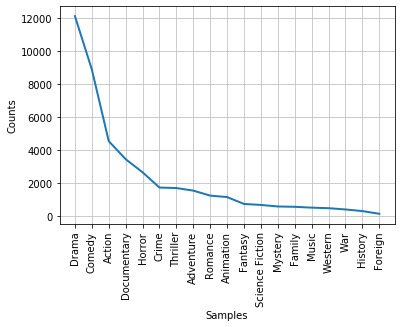

In [24]:
freq.plot(50, cumulative=False)